# Kronfluence Tutorial

Kronfluence is a repository designed to compute influence functions using Kronecker-factored Approximate Curvature (KFAC) or Eigenvalue-corrected KFAC (EKFAC). In this short tutorial, we will introduce some functionalities of Kronfluence on the UCI regression pipeline (it is quick to run and does not require GPUs).

In [265]:
import math
import random
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from tueplots import cycler, markers
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

from examples.uci.pipeline import get_regression_dataset

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(markers.with_edge())

## Setting up the Model and Dataset

Before computing influence scores, we need to prepare the trained model and datasets. Let's define the hyperparameters that we will use to train the model.

In [266]:
dataset_name = "concrete"
dataset_dir = "./data"
train_batch_size = 32
eval_batch_size = 128
num_train_epochs = 40
learning_rate = 0.03
weight_decay = 1e-05

After loading training and query (validation) datasets, we will train the model.

In [267]:
train_dataset = get_regression_dataset(data_name=dataset_name, split="train", dataset_dir=dataset_dir)
query_dataset = get_regression_dataset(data_name=dataset_name, split="valid", dataset_dir=dataset_dir)
train_dataset.data_x.shape, train_dataset.data_y.shape

((927, 8), (927, 1))

In [268]:
construct_regression_mlp()

Sequential(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)

In [269]:
def train(
    dataset: data.Dataset,
    batch_size: int,
    num_train_epochs: int,
    learning_rate: float,
    weight_decay: float,
    disable_tqdm: bool = False,
) -> nn.Module:
    train_dataloader = data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    model = construct_regression_mlp()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_train_epochs):
        total_loss = 0.0
        with tqdm(train_dataloader, unit="batch", disable=disable_tqdm) as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.zero_grad()
                inputs, targets = batch
                outputs = model(inputs)
                loss = F.mse_loss(outputs, targets)
                total_loss += loss.detach().float()
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=total_loss.item() / len(train_dataloader))
    return model

In [270]:
model = train(
    dataset=train_dataset,
    batch_size=train_batch_size,
    num_train_epochs=num_train_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 647.07batch/s, loss=0.0797]


We can compute the loss on the query dataset.

In [271]:
def evaluate(model: nn.Module, dataset: data.Dataset, batch_size: int) -> float:
    dataloader = data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    total_loss = 0.0
    for batch in dataloader:
        with torch.no_grad():
            inputs, targets = batch
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets, reduction="sum")
            total_loss += loss.detach().float()

    return total_loss.item() / len(dataloader.dataset)

evaluate(model=model, dataset=query_dataset, batch_size=eval_batch_size)

0.15210735913619255

## Defining a Task

Before computing influence scores, we need to define a `Task` class. This class encapsulates information about the trained model and how influence scores will be computed: (1) how to compute the training loss; (2) how to compute the measurement; (3) which modules to use for influence function computations; and (4) whether the model used attention mask.

In [162]:
from kronfluence.analyzer import Analyzer
from kronfluence.task import Task

We can use this helper function to easily get the name of available modules.

In [163]:
print(Analyzer.get_module_summary(model))

==Model Summary==
Module Name: `0`, Module: Linear(in_features=8, out_features=128, bias=True)
Module Name: `2`, Module: Linear(in_features=128, out_features=128, bias=True)
Module Name: `4`, Module: Linear(in_features=128, out_features=128, bias=True)
Module Name: `6`, Module: Linear(in_features=128, out_features=1, bias=True)


In [165]:
class RegressionTask(Task):
    def compute_train_loss(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, targets = batch
        outputs = model(inputs)
        if not sample:
            return F.mse_loss(outputs, targets, reduction="sum")
        # Sample the outputs from the model's prediction for Fisher.
        with torch.no_grad():
            sampled_targets = torch.normal(outputs, std=math.sqrt(0.5))
        return F.mse_loss(outputs, sampled_targets.detach(), reduction="sum")

    def compute_measurement(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
    ) -> torch.Tensor:
        # The measurement function is set as a training loss.
        return self.compute_train_loss(batch, model, sample=False)

    def tracked_modules(self) -> Optional[List[str]]:
        # These are the module names we will use to compute influence functions.
        return ["0", "2", "4", "6"]

Kronfluence wraps all supported modules within the model with `TrackedModule`. This wrapper will be used for computing the factors and influence scores. Once your model is ready and the task is defined, prepare your model with:

In [166]:
task = RegressionTask()
model = prepare_model(model, task)

You can see that the `TrackedModule` are now installed.

In [25]:
model

Sequential(
  (0): TrackedLinear(
    (original_module): Linear(in_features=8, out_features=128, bias=True)
  )
  (1): ReLU()
  (2): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=128, bias=True)
  )
  (3): ReLU()
  (4): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=128, bias=True)
  )
  (5): ReLU()
  (6): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=1, bias=True)
  )
)

We can define the `Analyzer` instance to compute influence scores.

In [27]:
analyzer = Analyzer(
    analysis_name="tutorial",
    model=model,
    task=task,
    cpu=True,
)

## Computing Influence Factors

We can compute the activation and pseudo-activation covariance matrices with `fit_covariance_matrices`.

In [167]:
analyzer.fit_covariance_matrices(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)
covariance_factors = analyzer.load_covariance_matrices(factors_name="tutorial_factor")

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


To access the activation covariance matrix for the first layer, we can run:

In [168]:
covariance_factors["activation_covariance"]["0"]

tensor([[ 9.2700e+02, -2.6189e+02, -3.6628e+02, -5.5314e+01,  7.6628e+01,
         -1.1040e+02, -2.0505e+02,  7.0193e+01,  7.0333e-06],
        [-2.6189e+02,  9.2700e+02, -2.9841e+02,  1.0027e+02,  3.5432e+01,
         -2.5665e+02, -2.6666e+02, -5.2741e+01,  9.9301e-05],
        [-3.6628e+02, -2.9841e+02,  9.2700e+02, -2.5373e+02,  3.5927e+02,
         -1.5643e+01,  7.8887e+01, -1.5043e+02, -7.6056e-05],
        [-5.5314e+01,  1.0027e+02, -2.5373e+02,  9.2700e+02, -6.0582e+02,
         -1.7789e+02, -4.1898e+02,  2.6212e+02,  3.2514e-05],
        [ 7.6628e+01,  3.5432e+01,  3.5927e+02, -6.0582e+02,  9.2700e+02,
         -2.4964e+02,  2.0808e+02, -1.7793e+02,  2.7895e-05],
        [-1.1040e+02, -2.5665e+02, -1.5643e+01, -1.7789e+02, -2.4964e+02,
          9.2700e+02, -1.5184e+02, -2.1742e+01, -1.1504e-05],
        [-2.0505e+02, -2.6666e+02,  7.8887e+01, -4.1898e+02,  2.0808e+02,
         -1.5184e+02,  9.2700e+02, -1.1600e+02,  9.4175e-06],
        [ 7.0193e+01, -5.2741e+01, -1.5043e+02, 

We can perform Eigendecomposition after fitting covariance matrices.

In [170]:
analyzer.perform_eigendecomposition(
    factors_name="tutorial_factor",
    overwrite_output_dir=True,
)

Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


Finally, we can fit the Lambda matrices with:

In [172]:
analyzer.fit_lambda_matrices(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]


While we sequentially called `fit_covariance_matrices`, `perform_eigendecomposition`, and `fit_lambda_matrices` in the above example, we can instead fit all required factors with:

In [174]:
analyzer.fit_all_factors(
    factors_name="tutorial_factor",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## Computing Influence Scores

After computing all neccessary factors, we can now compute the pairwise influence scores.

In [175]:
analyzer.compute_pairwise_scores(
    scores_name="tutorial_score",
    factors_name="tutorial_factor",
    query_dataset=query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(query_dataset),
    overwrite_output_dir=True,
)

Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                                           [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [1/1] 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Computing pairwise scores (query gradient) [0/1]   0%|                                                                                                                           [time left: ?, time spent: 00:00]
Computing pairwise scores (training gradient) [1/1] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████

You can load the pairwise scores with `load_pairwise_scores`. The pairwise score will have the dimension `query_dataset_size x train_dataset_size`.

In [176]:
scores = analyzer.load_pairwise_scores(scores_name="tutorial_score")
scores["all_modules"].shape

torch.Size([103, 927])

## Counterfactual Experiments

How would the model's behaviors on some query data point change if one or more data points were removed from the training dataset? We can use influence functions to identify influential training data points for a randomly selected query dataset.

In [210]:
import matplotlib.pyplot as plt

single_query_dataset = torch.utils.data.Subset(query_dataset, list(range(1)))
len(single_query_dataset)

1

We can compute the averaged loss this selected query data point obtains.

In [204]:
def train_and_evaluate(current_train_dataset: data.Dataset, current_eval_dataset: data.Dataset) -> float:
    current_model = train(
        dataset=current_train_dataset,
        batch_size=train_batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        disable_tqdm=True,
    )
    return evaluate(model=current_model, dataset=current_eval_dataset, batch_size=eval_batch_size)

In [234]:
num_iter = 20
base_loss = 0
for _ in range(num_iter):
    base_loss += train_and_evaluate(current_train_dataset=train_dataset, current_eval_dataset=single_query_dataset)
base_loss /= num_iter

In [235]:
base_loss

0.07577588451167686

We compute top influential data points for this query dataset.

In [208]:
analyzer.fit_all_factors(
    factors_name="counterfactual_factors",
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)
analyzer.compute_pairwise_scores(
    scores_name="counterfactual_scores",
    factors_name="counterfactual_factors",
    query_dataset=single_query_dataset,
    train_dataset=train_dataset,
    per_device_query_batch_size=len(single_query_dataset),
    overwrite_output_dir=True,
)
scores = analyzer.load_pairwise_scores(scores_name="counterfactual_scores")

Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [4/4] 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

We can plot the distribution of influence scores.

Text(0, 0.5, 'Scores')

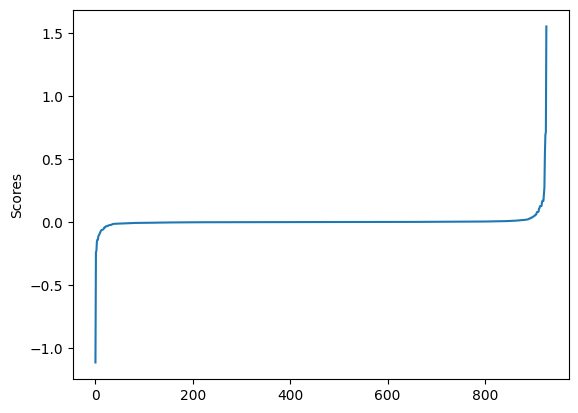

In [217]:
plt.plot(sorted(scores["all_modules"].sum(dim=0) / len(train_dataset)))
plt.ylabel("Scores")

What happens if we train the model without the positively influential data points?

In [222]:
def get_topk_indices(current_score: torch.Tensor, topk: int = 1) -> torch.Tensor:
    return torch.topk(current_score, topk).indices

def get_topk_keep_indices(current_score: torch.Tensor, topk: int = 1) -> List[int]:
    remove_indices = get_topk_indices(current_score, topk)
    remove_indices = [tensor.item() for tensor in remove_indices]
    return list(set(list(range(len(train_dataset)))) - set(remove_indices))

`get_topk_keep_indices` returns dataset indices with `topk` positively influential data points removed.

In [227]:
len(get_topk_keep_indices(summed_scores, topk=10))

917

In [236]:
topk_lst = [20, 40, 60, 80, 100, 120] 
averaged_loss_lst = []

for topk in topk_lst:
    keep_indices = get_topk_keep_indices(summed_scores, topk=topk)
    
    new_loss = 0
    for _ in range(num_iter):
        new_loss += train_and_evaluate(current_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), current_eval_dataset=single_query_dataset)
    new_loss /= num_iter
    averaged_loss_lst.append(new_loss)

Text(0.5, 0, 'Number of Training Samples Removed')

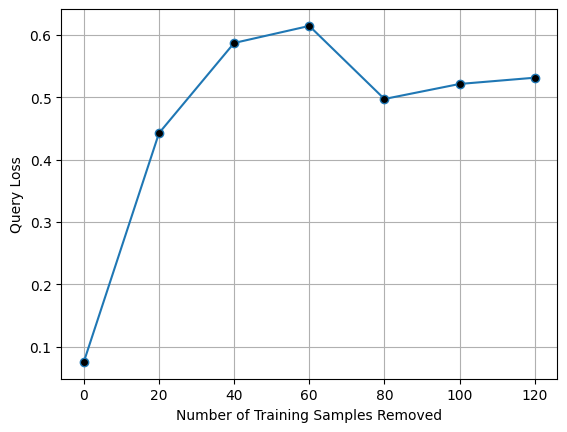

In [240]:
plt.plot([0] + topk_lst, [base_loss] + averaged_loss_lst, "o-", markerfacecolor="k")
plt.grid()
plt.ylabel("Query Loss")
plt.xlabel("Number of Training Samples Removed")

In [250]:
random_indices

We can compare influence estimates with random data removal baseline.

In [254]:
from random import shuffle

random_indices = list(range(summed_scores.shape[0]))
shuffle(random_indices)

In [259]:
random_averaged_loss_lst = []

for topk in topk_lst:
    keep_indices = random_indices[topk:]
    
    new_loss = 0
    for _ in range(num_iter):
        new_loss += train_and_evaluate(current_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), current_eval_dataset=single_query_dataset)
    new_loss /= num_iter
    random_averaged_loss_lst.append(new_loss)

Text(0.5, 0, 'Number of Training Samples Removed')

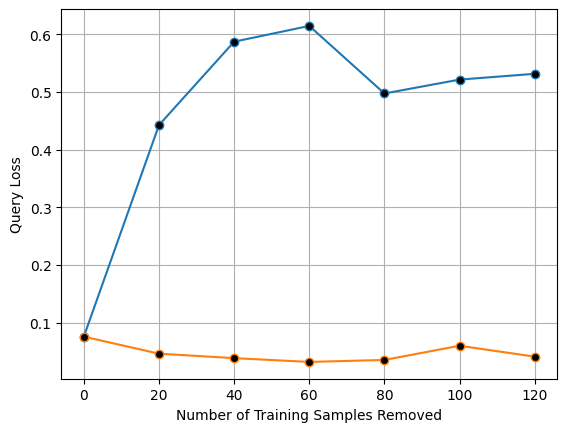

In [260]:
plt.plot([0] + topk_lst, [base_loss] + averaged_loss_lst, "o-", markerfacecolor="k", label="IF")
plt.plot([0] + topk_lst, [base_loss] + random_averaged_loss_lst, "o-", markerfacecolor="k", label="Random")
plt.grid()
plt.ylabel("Query Loss")
plt.xlabel("Number of Training Samples Removed")

Influence functions can also help us find negatively influential data points. We can repeat the analysis above.

In [261]:
negative_averaged_loss_lst = []

for topk in topk_lst:
    keep_indices = get_topk_keep_indices(-summed_scores, topk=topk)
    
    new_loss = 0
    for _ in range(num_iter):
        new_loss += train_and_evaluate(current_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), current_eval_dataset=single_query_dataset)
    new_loss /= num_iter
    negative_averaged_loss_lst.append(new_loss)

Text(0.5, 0, 'Number of Training Samples Removed')

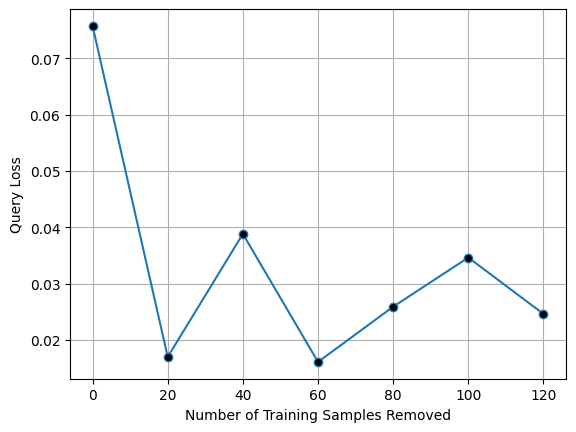

In [262]:
plt.plot([0] + topk_lst, [base_loss] + negative_averaged_loss_lst, "o-", markerfacecolor="k", label="IF")
plt.grid()
plt.ylabel("Query Loss")
plt.xlabel("Number of Training Samples Removed")